In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
try:
    movie_data = pd.read_csv(r'C:\Users\HP\Desktop\Codsoft\Data Science\IMDB movieclassification dataset\IMDb Movies India.csv', encoding='ISO-8859-1')
    dataset_info = movie_data.info()
    first_five_rows = movie_data.head()
    successful_load = True
except Exception as e:
    dataset_info = str(e)
    first_five_rows = None
    successful_load = False

successful_load, dataset_info, first_five_rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


(True,
 None,
                                  Name    Year Duration            Genre  \
 0                                         NaN      NaN            Drama   
 1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
 2                         #Homecoming  (2021)   90 min   Drama, Musical   
 3                             #Yaaram  (2019)  110 min  Comedy, Romance   
 4                   ...And Once Again  (2010)  105 min            Drama   
 
    Rating Votes            Director       Actor 1             Actor 2  \
 0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
 1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
 2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
 3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
 4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   
 
            Actor 3  
 0  Rajendra Bhatia  
 1    Arvind Jangid  
 2       Roy Ang

In [3]:
# Removing rows with missing values in the 'Rating' column
movie_data_cleaned = movie_data.dropna(subset=['Rating'])

# Checking the number of missing values in each column after removal
missing_values = movie_data_cleaned.isnull().sum()
total_rows_after_removal = movie_data_cleaned.shape[0]

missing_values, total_rows_after_removal


(Name           0
 Year           0
 Duration    2068
 Genre        102
 Rating         0
 Votes          0
 Director       5
 Actor 1      125
 Actor 2      200
 Actor 3      292
 dtype: int64,
 7919)

In [4]:
# Removing rows with missing values in columns 
columns_to_clean = ['Genre', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
movie_data_cleaned = movie_data_cleaned.dropna(subset=columns_to_clean)

In [6]:
# Handling missing values in 'Duration'
#fill missing values of duration with the mean duration
movie_data_cleaned['Duration'] = movie_data_cleaned['Duration'].str.extract('(\d+)').astype(float)
mean_duration = movie_data_cleaned['Duration'].mean()
movie_data_cleaned['Duration'].fillna(mean_duration, inplace=True)


In [7]:
# Checking the number of missing values in each column after cleaning
missing_values_after_cleaning = movie_data_cleaned.isnull().sum()
total_rows_after_final_cleaning = movie_data_cleaned.shape[0]

missing_values_after_cleaning, total_rows_after_final_cleaning

(Name        0
 Year        0
 Duration    0
 Genre       0
 Rating      0
 Votes       0
 Director    0
 Actor 1     0
 Actor 2     0
 Actor 3     0
 dtype: int64,
 7558)

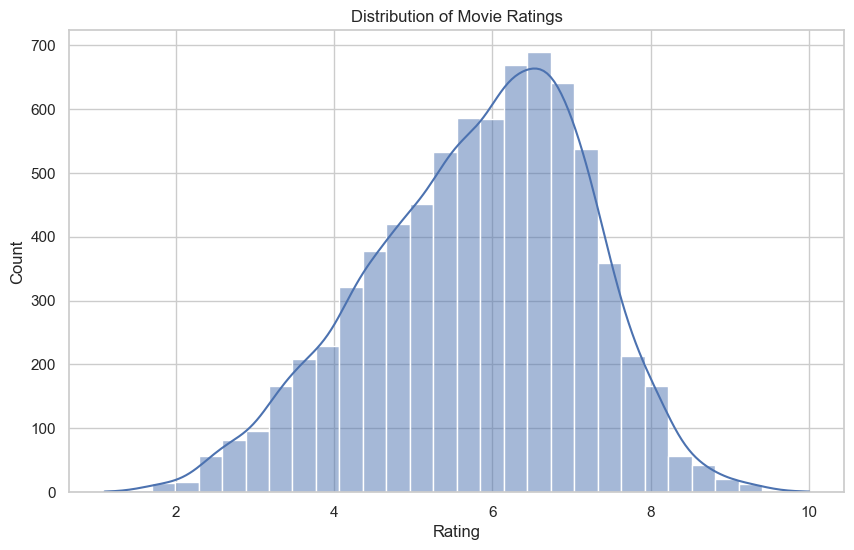

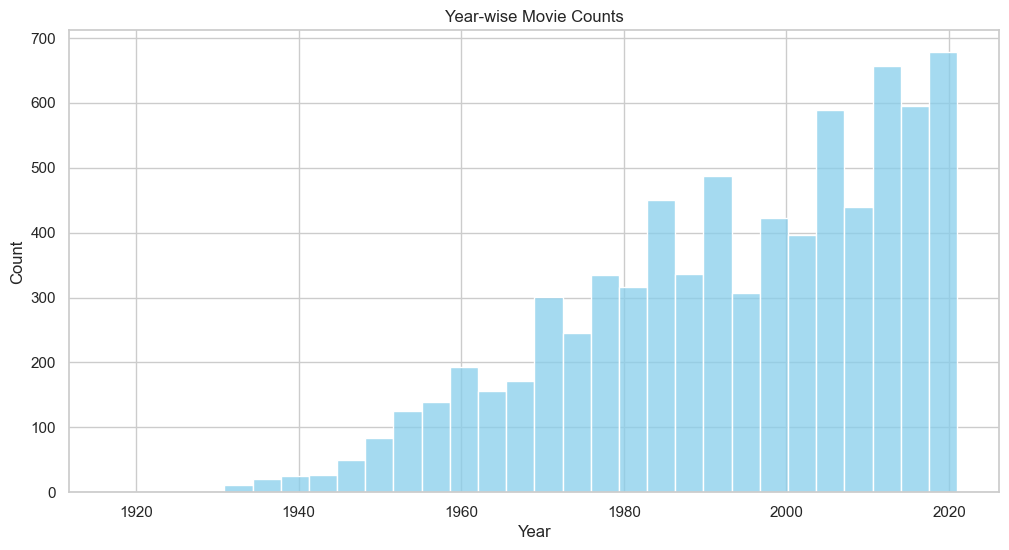

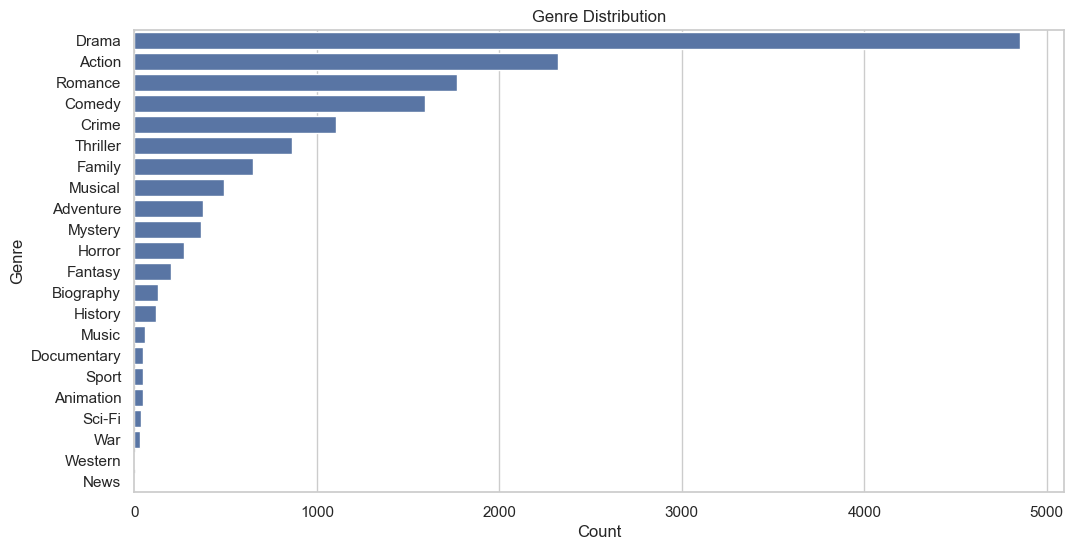

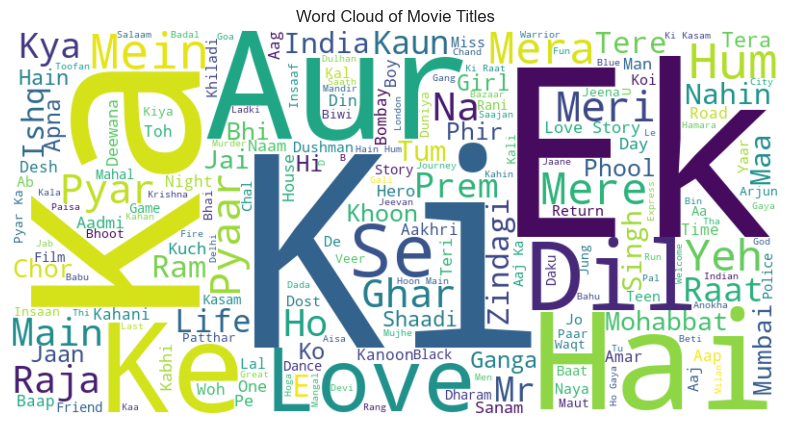

In [8]:

sns.set(style="whitegrid")

# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_data_cleaned['Rating'], kde=True, bins=30)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Year-wise Movie Counts
movie_data_cleaned['Year'] = movie_data_cleaned['Year'].str.extract('(\d+)').astype(float)

plt.figure(figsize=(12, 6))
sns.histplot(movie_data_cleaned['Year'].dropna(), bins=30, kde=False, color='skyblue')
plt.title('Year-wise Movie Counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Genre Distribution
all_genres = movie_data_cleaned['Genre'].str.split(', ').explode()
plt.figure(figsize=(12, 6))
sns.countplot(y=all_genres, order=all_genres.value_counts().index)
plt.title('Genre Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Preparing data for word cloud of movie titles
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(movie_data_cleaned['Name']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()



In [13]:
# Feature Transformation
current_year = 2023


movie_data_cleaned['Year'] = movie_data_cleaned['Year'].astype(str)
movie_data_cleaned['Movie_Age'] = current_year - movie_data_cleaned['Year'].str.extract('(\d+)').astype(float)

# Checking the data type of 'Votes' column and converting if necessary
if movie_data_cleaned['Votes'].dtype == 'object':
    movie_data_cleaned['Votes'] = movie_data_cleaned['Votes'].str.replace(',', '').astype(float)
elif movie_data_cleaned['Votes'].dtype in ['int', 'float']:
   
    pass
else:
    print("Warning: The 'Votes' column has an unexpected data type.")


In [14]:
# Advanced Categorical Encoding
categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
for col in categorical_cols:
    mean_encoding = movie_data_cleaned.groupby(col)['Rating'].mean()
    movie_data_cleaned[col + '_Rating_Mean'] = movie_data_cleaned[col].map(mean_encoding)

# Textual Data Handling - TF-IDF on 'Name'
tfidf = TfidfVectorizer(max_features=50)
tfidf_features = tfidf.fit_transform(movie_data_cleaned['Name']).toarray()
tfidf_feature_names = ['title_tfidf_' + str(i) for i in range(tfidf_features.shape[1])]
movie_data_cleaned[tfidf_feature_names] = tfidf_features


In [15]:
# Feature Engineering - Polynomial Features for 'Duration' and 'Movie_Age'
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(movie_data_cleaned[['Duration', 'Movie_Age']])
poly_feature_names = poly.get_feature_names_out(['Duration', 'Movie_Age'])
movie_data_cleaned[poly_feature_names] = poly_features

# Scaling - StandardScaler for numerical features
scaler = StandardScaler()

numerical_cols = ['Duration', 'Movie_Age', 'Votes'] + [col + '_Rating_Mean' for col in categorical_cols] + list(poly_feature_names)
movie_data_cleaned[numerical_cols] = scaler.fit_transform(movie_data_cleaned[numerical_cols])


In [16]:
# Splitting the dataset into features (X) and target variable (y)
X = movie_data_cleaned.drop('Rating', axis=1).select_dtypes(include=np.number)
y = movie_data_cleaned['Rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing models
linear_reg = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Training and evaluating each model
linear_reg_metrics = train_and_evaluate(linear_reg, X_train, y_train, X_test, y_test)
random_forest_metrics = train_and_evaluate(random_forest, X_train, y_train, X_test, y_test)
gradient_boosting_metrics = train_and_evaluate(gradient_boosting, X_train, y_train, X_test, y_test)

# Preparing the results table
results = {
    'Model': ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor'],
    'MSE': [linear_reg_metrics[0], random_forest_metrics[0], gradient_boosting_metrics[0]],
    'MAE': [linear_reg_metrics[1], random_forest_metrics[1], gradient_boosting_metrics[1]],
    'R²': [linear_reg_metrics[2], random_forest_metrics[2], gradient_boosting_metrics[2]]
}

results_df = pd.DataFrame(results)
results_df



,Model,MSE,MAE,R²
0,Linear Regression,0.451755,0.501318,0.756182
1,Random Forest Regressor,0.375310,0.426396,0.797440
2,Gradient Boosting Regressor,0.382704,0.450198,0.793450
